#Klasifikasi Teks Naive Bayes

In [1]:
!pip install ekphrasis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10


In [1]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [3]:
import re
import string
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
df = pd.read_csv('dataset_komentar_instagram_cyberbullying.csv')

In [7]:
df.head()

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


#Mengubah Sentiment menggunakan proses Mapping

In [8]:
sentimen_mapping = {'negative': -1.0, 'neutral': 0.0, 'positive': 1.0}

In [10]:
df['Sentiment'] = df['Sentiment'].map(sentimen_mapping)

In [11]:
print(df)

      Id  Sentiment                             Instagram Comment Text
0      1       -1.0   <USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1      2       -1.0  Geblek lo tata...cowo bgt dibela2in balikan......
2      3       -1.0  Kmrn termewek2 skr lengket lg duhhh kok labil ...
3      4       -1.0  Intinya kalau kesel dengan ATT nya, gausah ke ...
4      5       -1.0  hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...
..   ...        ...                                                ...
395  396        1.0  Bangga sama suami yg selalu ingat istri disela...
396  397        1.0  Apaoun pekerjaannya yg penting halal u tuk men...
397  398        1.0  Gojek itu mayoritas pegangguran yang lama gak ...
398  399        1.0   <USERNAME> aslinya cantik dan ayu loh mbak kr...
399  400        1.0   <USERNAME> suami saya seumuran sama saya mba,...

[400 rows x 3 columns]


#Preprocessing Text

In [12]:
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text)

In [14]:
final_string = []
for text in df['Instagram Comment Text'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc)
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

In [15]:
df["step01"] = final_string

In [16]:
df.head()

,Id,Sentiment,Instagram Comment Text,step01
0,1,-1.0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,allcaps username allcaps allcaps tolol allcaps...
1,2,-1.0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata repeated cowo bgt dibela2in bal...
2,3,-1.0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek2 skr lengket lg duh elongated ko...
3,4,-1.0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan allcaps att allcaps...
4,5,-1.0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadeww elongated permpuan itu lg repeated saki...


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      400 non-null    int64  
 1   Sentiment               400 non-null    float64
 2   Instagram Comment Text  400 non-null    object 
 3   step01                  400 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 12.6+ KB


In [18]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [19]:
df_new = df[~df.isin(df_hapus)].dropna()

In [20]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      400 non-null    int64  
 1   Sentiment               400 non-null    float64
 2   Instagram Comment Text  400 non-null    object 
 3   step01                  400 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 12.6+ KB


#Normalisasi

In [21]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [23]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [24]:
df_new.head(10)

,Id,Sentiment,Instagram Comment Text,step01,tokens
0,1,-1.0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,allcaps username allcaps allcaps tolol allcaps...,"[allcaps, username, allcaps, allcaps, tolol, a..."
1,2,-1.0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata repeated cowo bgt dibela2in bal...,"[geblek, lo, tata, repeated, cowo, bgt, dibela..."
2,3,-1.0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek2 skr lengket lg duh elongated ko...,"[kmrn, termewek2, skr, lengket, lg, duh, elong..."
3,4,-1.0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan allcaps att allcaps...,"[intinya, kalau, kesel, dengan, allcaps, att, ..."
4,5,-1.0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadeww elongated permpuan itu lg repeated saki...,"[hadeww, elongated, permpuan, itu, lg, repeate..."
5,6,-1.0,"Pantesan di tinggalin laki, ya lakinya juga mi...",pantesan di tinggalin laki ya lakinya juga mik...,"[pantesan, di, tinggalin, laki, ya, lakinya, j..."
6,7,-1.0,kebiasaan balajaer nyampah d ig para artis..su...,kebiasaan balajaer nyampah ig para artis repea...,"[kebiasaan, balajaer, nyampah, ig, para, artis..."
7,8,-1.0,krn sebagian besar rakyat indonesia itu bodoh....,krn sebagian besar rakyat indonesia itu bodoh ...,"[krn, sebagian, besar, rakyat, indonesia, itu,..."
8,9,-1.0,ayu janda bego pny suami kpn nikah laginya?,ayu janda bego pny suami kpn nikah laginya,"[ayu, janda, bego, pny, suami, kpn, nikah, lag..."
9,10,-1.0,"Anyiennnnggg.. Suaranya ancur banget, lebih me...",anyienngg elongated repeated suaranya ancur ba...,"[anyienngg, elongated, repeated, suaranya, anc..."


In [29]:
normalized_word = pd.read_excel("kamus perbaikan kata.xlsx")

In [30]:
normalized_word_dict = {}

In [31]:
for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

In [32]:
def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

In [33]:
df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

In [34]:
df_new.head()

,Id,Sentiment,Instagram Comment Text,step01,tokens,tokens_perbaikan
0,1,-1.0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,allcaps username allcaps allcaps tolol allcaps...,"[allcaps, username, allcaps, allcaps, tolol, a...","[allcaps, username, allcaps, allcaps, tolol, a..."
1,2,-1.0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata repeated cowo bgt dibela2in bal...,"[geblek, lo, tata, repeated, cowo, bgt, dibela...","[geblek, lo, tata, repeated, cowo, banget, dib..."
2,3,-1.0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek2 skr lengket lg duh elongated ko...,"[kmrn, termewek2, skr, lengket, lg, duh, elong...","[kmrn, termewek2, skr, lengket, lg, aduh, elon..."
3,4,-1.0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan allcaps att allcaps...,"[intinya, kalau, kesel, dengan, allcaps, att, ...","[intinya, kalau, kesal, dengan, allcaps, att, ..."
4,5,-1.0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadeww elongated permpuan itu lg repeated saki...,"[hadeww, elongated, permpuan, itu, lg, repeate...","[hadeww, elongated, permpuan, itu, lg, repeate..."


In [35]:
df_new.iloc[0].tokens

['allcaps',
 'username',
 'allcaps',
 'allcaps',
 'tolol',
 'allcaps',
 'repeated',
 'gak',
 'ada',
 'hubungan',
 'nya',
 'keguguran',
 'dgn',
 'pake',
 'hijab',
 'syar',
 'yg',
 'lo',
 'bilang',
 'bayi',
 'nya',
 'kepanasan',
 'didalem',
 'gak',
 'ada',
 'hubungan',
 'nya',
 'woy',
 'elongated',
 'repeated',
 'otak',
 'sama',
 'jempol',
 'lo',
 'gak',
 'singkron',
 'sih',
 'ya',
 'jadinya',
 'asal',
 'nulis',
 'komentar']

In [36]:
df_new.iloc[0].tokens_perbaikan

['allcaps',
 'username',
 'allcaps',
 'allcaps',
 'tolol',
 'allcaps',
 'repeated',
 'tidak',
 'ada',
 'hubungan',
 'nya',
 'keguguran',
 'dengan',
 'pakai',
 'hijab',
 'syar',
 'yang',
 'lo',
 'bilang',
 'bayi',
 'nya',
 'kepanasan',
 'didalem',
 'tidak',
 'ada',
 'hubungan',
 'nya',
 'woy',
 'elongated',
 'repeated',
 'otak',
 'sama',
 'jempol',
 'lo',
 'tidak',
 'singkron',
 'sih',
 'ya',
 'jadinya',
 'asal',
 'nulis',
 'komentar']

#Stopword

In [37]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
stopword = nltk.corpus.stopwords.words('indonesian')

In [39]:
def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text


In [40]:
df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Id,Sentiment,Instagram Comment Text,step01,tokens,tokens_perbaikan,Stop_removal
0,1,-1.0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,allcaps username allcaps allcaps tolol allcaps...,"[allcaps, username, allcaps, allcaps, tolol, a...","[allcaps, username, allcaps, allcaps, tolol, a...","[allcaps, username, allcaps, allcaps, tolol, a..."
1,2,-1.0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata repeated cowo bgt dibela2in bal...,"[geblek, lo, tata, repeated, cowo, bgt, dibela...","[geblek, lo, tata, repeated, cowo, banget, dib...","[geblek, lo, tata, repeated, cowo, banget, dib..."
2,3,-1.0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek2 skr lengket lg duh elongated ko...,"[kmrn, termewek2, skr, lengket, lg, duh, elong...","[kmrn, termewek2, skr, lengket, lg, aduh, elon...","[kmrn, termewek2, skr, lengket, lg, aduh, elon..."
3,4,-1.0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan allcaps att allcaps...,"[intinya, kalau, kesel, dengan, allcaps, att, ...","[intinya, kalau, kesal, dengan, allcaps, att, ...","[intinya, kesal, allcaps, att, allcaps, nya, g..."
4,5,-1.0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadeww elongated permpuan itu lg repeated saki...,"[hadeww, elongated, permpuan, itu, lg, repeate...","[hadeww, elongated, permpuan, itu, lg, repeate...","[hadeww, elongated, permpuan, lg, repeated, sa..."
...,...,...,...,...,...,...,...
395,396,1.0,Bangga sama suami yg selalu ingat istri disela...,bangga sama suami yg selalu ingat istri disela...,"[bangga, sama, suami, yg, selalu, ingat, istri...","[bangga, sama, suami, yang, selalu, ingat, ist...","[bangga, suami, istri, disela, apapun, profesi..."
396,397,1.0,Apaoun pekerjaannya yg penting halal u tuk men...,apaoun pekerjaannya yg penting halal tuk menaf...,"[apaoun, pekerjaannya, yg, penting, halal, tuk...","[apaoun, pekerjaannya, yang, penting, halal, t...","[apaoun, pekerjaannya, halal, tuk, menafkahi, ..."
397,398,1.0,Gojek itu mayoritas pegangguran yang lama gak ...,gojek itu mayoritas pegangguran yang lama gak ...,"[gojek, itu, mayoritas, pegangguran, yang, lam...","[gojek, itu, mayoritas, pegangguran, yang, lam...","[gojek, mayoritas, pegangguran, kerja, putus, ..."
398,399,1.0,<USERNAME> aslinya cantik dan ayu loh mbak kr...,allcaps username allcaps aslinya cantik dan ay...,"[allcaps, username, allcaps, aslinya, cantik, ...","[allcaps, username, allcaps, aslinya, cantik, ...","[allcaps, username, allcaps, aslinya, cantik, ..."


In [41]:
df_new.iloc[0].tokens_perbaikan

['allcaps',
 'username',
 'allcaps',
 'allcaps',
 'tolol',
 'allcaps',
 'repeated',
 'tidak',
 'ada',
 'hubungan',
 'nya',
 'keguguran',
 'dengan',
 'pakai',
 'hijab',
 'syar',
 'yang',
 'lo',
 'bilang',
 'bayi',
 'nya',
 'kepanasan',
 'didalem',
 'tidak',
 'ada',
 'hubungan',
 'nya',
 'woy',
 'elongated',
 'repeated',
 'otak',
 'sama',
 'jempol',
 'lo',
 'tidak',
 'singkron',
 'sih',
 'ya',
 'jadinya',
 'asal',
 'nulis',
 'komentar']

In [42]:
df_new.iloc[0].Stop_removal

['allcaps',
 'username',
 'allcaps',
 'allcaps',
 'tolol',
 'allcaps',
 'repeated',
 'hubungan',
 'nya',
 'keguguran',
 'pakai',
 'hijab',
 'syar',
 'lo',
 'bilang',
 'bayi',
 'nya',
 'kepanasan',
 'didalem',
 'hubungan',
 'nya',
 'woy',
 'elongated',
 'repeated',
 'otak',
 'jempol',
 'lo',
 'singkron',
 'sih',
 'ya',
 'nulis',
 'komentar']

In [43]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [44]:
df_new["step02"] = final_string_tokens

In [45]:
df_new.head()

,Id,Sentiment,Instagram Comment Text,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,1,-1.0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,allcaps username allcaps allcaps tolol allcaps...,"[allcaps, username, allcaps, allcaps, tolol, a...","[allcaps, username, allcaps, allcaps, tolol, a...","[allcaps, username, allcaps, allcaps, tolol, a...",allcaps username allcaps allcaps tolol allcaps...
1,2,-1.0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata repeated cowo bgt dibela2in bal...,"[geblek, lo, tata, repeated, cowo, bgt, dibela...","[geblek, lo, tata, repeated, cowo, banget, dib...","[geblek, lo, tata, repeated, cowo, banget, dib...",geblek lo tata repeated cowo banget dibela2in ...
2,3,-1.0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek2 skr lengket lg duh elongated ko...,"[kmrn, termewek2, skr, lengket, lg, duh, elong...","[kmrn, termewek2, skr, lengket, lg, aduh, elon...","[kmrn, termewek2, skr, lengket, lg, aduh, elon...",kmrn termewek2 skr lengket lg aduh elongated l...
3,4,-1.0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan allcaps att allcaps...,"[intinya, kalau, kesel, dengan, allcaps, att, ...","[intinya, kalau, kesal, dengan, allcaps, att, ...","[intinya, kesal, allcaps, att, allcaps, nya, g...",intinya kesal allcaps att allcaps nya gausah a...
4,5,-1.0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadeww elongated permpuan itu lg repeated saki...,"[hadeww, elongated, permpuan, itu, lg, repeate...","[hadeww, elongated, permpuan, itu, lg, repeate...","[hadeww, elongated, permpuan, lg, repeated, sa...",hadeww elongated permpuan lg repeated sakit ji...


#Stemming

In [46]:
!pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.8 MB/s eta 0:00:00


In [47]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [50]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)

    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [51]:
df_new["ProcessedText"] = final_string

In [52]:
df_new.head(10)

,Id,Sentiment,Instagram Comment Text,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,1,-1.0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,allcaps username allcaps allcaps tolol allcaps...,"[allcaps, username, allcaps, allcaps, tolol, a...","[allcaps, username, allcaps, allcaps, tolol, a...","[allcaps, username, allcaps, allcaps, tolol, a...",allcaps username allcaps allcaps tolol allcaps...,allcaps username allcaps allcaps tolol allcaps...
1,2,-1.0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tata repeated cowo bgt dibela2in bal...,"[geblek, lo, tata, repeated, cowo, bgt, dibela...","[geblek, lo, tata, repeated, cowo, banget, dib...","[geblek, lo, tata, repeated, cowo, banget, dib...",geblek lo tata repeated cowo banget dibela2in ...,geblek lo tata repeated cowo banget dibela2in ...
2,3,-1.0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek2 skr lengket lg duh elongated ko...,"[kmrn, termewek2, skr, lengket, lg, duh, elong...","[kmrn, termewek2, skr, lengket, lg, aduh, elon...","[kmrn, termewek2, skr, lengket, lg, aduh, elon...",kmrn termewek2 skr lengket lg aduh elongated l...,kmrn termewek2 skr lengket lg aduh elongated l...
3,4,-1.0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan allcaps att allcaps...,"[intinya, kalau, kesel, dengan, allcaps, att, ...","[intinya, kalau, kesal, dengan, allcaps, att, ...","[intinya, kesal, allcaps, att, allcaps, nya, g...",intinya kesal allcaps att allcaps nya gausah a...,inti kesal allcaps att allcaps nya gausah anak...
4,5,-1.0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadeww elongated permpuan itu lg repeated saki...,"[hadeww, elongated, permpuan, itu, lg, repeate...","[hadeww, elongated, permpuan, itu, lg, repeate...","[hadeww, elongated, permpuan, lg, repeated, sa...",hadeww elongated permpuan lg repeated sakit ji...,hadeww elongated permpuan lg repeated sakit ji...
5,6,-1.0,"Pantesan di tinggalin laki, ya lakinya juga mi...",pantesan di tinggalin laki ya lakinya juga mik...,"[pantesan, di, tinggalin, laki, ya, lakinya, j...","[pantesan, di, tinggalin, laki, ya, lakinya, j...","[pantesan, tinggalin, laki, ya, lakinya, mikir...",pantesan tinggalin laki ya lakinya mikir kali ...,pantesan tinggalin laki ya laki mikir kali per...
6,7,-1.0,kebiasaan balajaer nyampah d ig para artis..su...,kebiasaan balajaer nyampah ig para artis repea...,"[kebiasaan, balajaer, nyampah, ig, para, artis...","[kebiasaan, balajaer, nyampah, ig, para, artis...","[kebiasaan, balajaer, nyampah, ig, artis, repe...",kebiasaan balajaer nyampah ig artis repeated s...,biasa balajaer nyampah ig artis repeated suka2...
7,8,-1.0,krn sebagian besar rakyat indonesia itu bodoh....,krn sebagian besar rakyat indonesia itu bodoh ...,"[krn, sebagian, besar, rakyat, indonesia, itu,...","[karena, sebagian, besar, rakyat, indonesia, i...","[rakyat, indonesia, bodoh, membedakan, buruk, ...",rakyat indonesia bodoh membedakan buruk tau pr...,rakyat indonesia bodoh beda buruk tau prilaku ...
8,9,-1.0,ayu janda bego pny suami kpn nikah laginya?,ayu janda bego pny suami kpn nikah laginya,"[ayu, janda, bego, pny, suami, kpn, nikah, lag...","[ayu, janda, bego, pny, suami, kapan, nikah, l...","[ayu, janda, bego, pny, suami, nikah, laginya]",ayu janda bego pny suami nikah laginya,ayu janda bego pny suami nikah lagi
9,10,-1.0,"Anyiennnnggg.. Suaranya ancur banget, lebih me...",anyienngg elongated repeated suaranya ancur ba...,"[anyienngg, elongated, repeated, suaranya, anc...","[anyienngg, elongated, repeated, suaranya, han...","[anyienngg, elongated, repeated, suaranya, han...",anyienngg elongated repeated suaranya hancur b...,anyienngg elongated repeated suara hancur bang...


#Menyimpan data hasil

In [53]:
df_new.to_csv('clean_dataset.csv',sep=";")

#Data Management

In [54]:
import pandas as pd
import numpy as np

In [55]:
dataset = pd.read_csv('clean_dataset.csv',sep=";")

In [56]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              400 non-null    int64  
 1   Id                      400 non-null    int64  
 2   Sentiment               400 non-null    float64
 3   Instagram Comment Text  400 non-null    object 
 4   step01                  400 non-null    object 
 5   tokens                  400 non-null    object 
 6   tokens_perbaikan        400 non-null    object 
 7   Stop_removal            400 non-null    object 
 8   step02                  400 non-null    object 
 9   ProcessedText           400 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 31.4+ KB


In [57]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [58]:
dataset_feature.head(10)

0    allcaps username allcaps allcaps tolol allcaps...
1    geblek lo tata repeated cowo banget dibela2in ...
2    kmrn termewek2 skr lengket lg aduh elongated l...
3    inti kesal allcaps att allcaps nya gausah anak...
4    hadeww elongated permpuan lg repeated sakit ji...
5    pantesan tinggalin laki ya laki mikir kali per...
6    biasa balajaer nyampah ig artis repeated suka2...
7    rakyat indonesia bodoh beda buruk tau prilaku ...
8                  ayu janda bego pny suami nikah lagi
9    anyienngg elongated repeated suara hancur bang...
Name: ProcessedText, dtype: object

In [59]:
dataset_label = dataset['Sentiment']

In [60]:
dataset_label.head(10)

0   -1.0
1   -1.0
2   -1.0
3   -1.0
4   -1.0
5   -1.0
6   -1.0
7   -1.0
8   -1.0
9   -1.0
Name: Sentiment, dtype: float64

#Distribusi Label

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<ipython-input-62-49fa269dbac5>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')


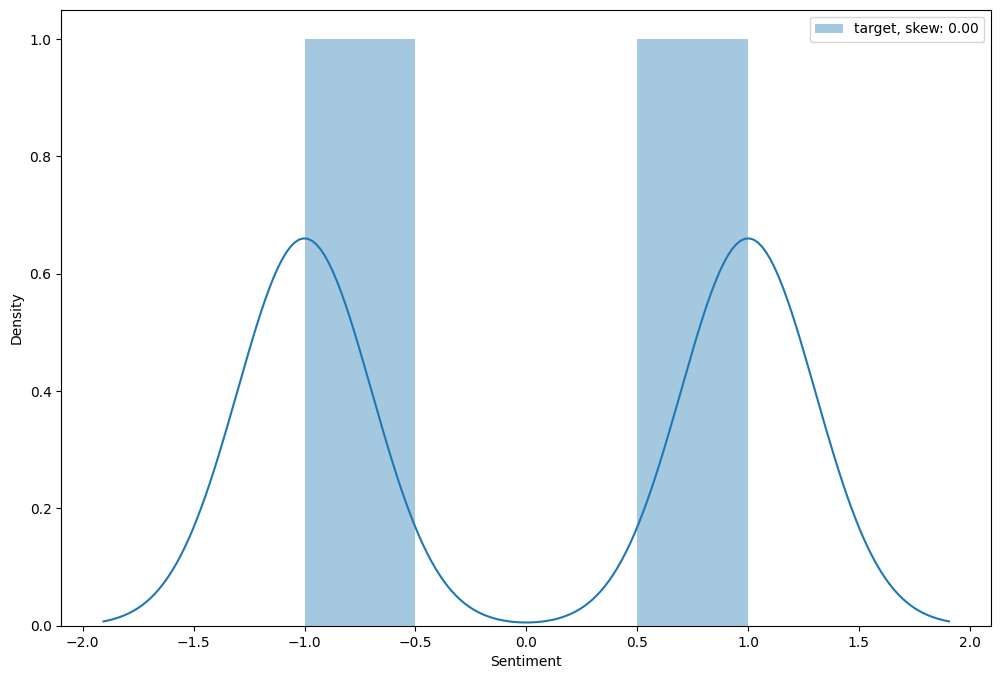

In [62]:
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

In [63]:
dataset_label.value_counts()

-1.0    200
 1.0    200
Name: Sentiment, dtype: int64

#Machine Learning

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [65]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

In [66]:
test_x

209    bagus repeated cari ilmu mana repeated suami o...
280          bagi suara cocok bnget pecah suara jg cakep
33     cowok anjing cuihh elongated repeated orang ka...
210          sukak cewe cantik kmauan blajarnya repeated
93                       suka orang idupnya banyak ribut
                             ...                        
60     allcaps username allcaps kampung loh pakai ker...
79     salfok muka sumpah jelek repeated oplas model ...
285    keren min orang2 bakat kaya gin up publik repe...
305    manusia harga tulis tulis guna sakit hati oran...
281    keren banget suara tinggal permak biar tmbh ca...
Name: ProcessedText, Length: 120, dtype: object

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

In [69]:
from sklearn.naive_bayes import MultinomialNB

In [70]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [71]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [72]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [73]:
classifier_nb.fit(train_x, train_label.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [74]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  1.0
Accuracy Test set:  0.9


In [75]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  1.0
Recall Test set:  0.9


In [76]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  1.0
Precision Test set:  0.9


In [77]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  1.0
F1 Test set:  0.9


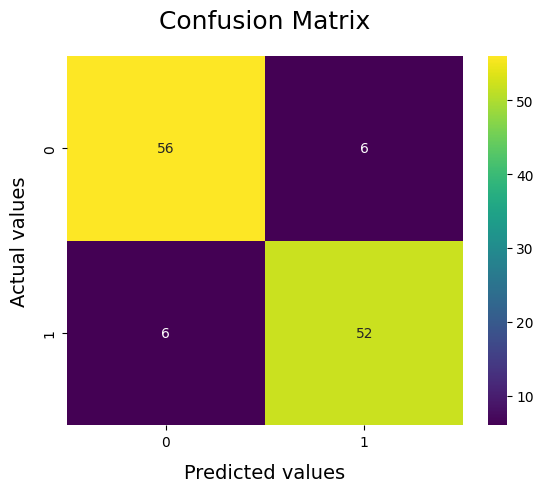

In [78]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [79]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', MultinomialNB(alpha=1))])

In [80]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 1
tfidf__ngram_range: (1, 1)


#KNN

In [82]:
from sklearn.neighbors import KNeighborsClassifier

In [83]:
train_x.dtype

dtype('O')

In [85]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_x_encoded = label_encoder.fit_transform(train_x)

In [88]:
test_x_encoded = label_encoder.fit_transform(test_x)

In [89]:
train_x_encoded.dtype

dtype('int64')

In [90]:
train_x_encoded = train_x_encoded.reshape(-1, 1)

In [91]:
test_x_encoded = test_x_encoded.reshape(-1, 1)

In [92]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_x_encoded, train_label)

KNeighborsClassifier(n_neighbors=3)

In [94]:
y_pred_knn_train = model.predict(train_x_encoded)
accuracy_knn_train = accuracy_score(train_label, y_pred_knn_train)
print("Accuracy Training set: ", accuracy_knn_train)

y_pred_knn_test = model.predict(test_x_encoded)
accuracy_knn_test = accuracy_score(test_label, y_pred_knn_test)
print("Accuracy Test set: ", accuracy_knn_test)

Accuracy Training set:  0.8392857142857143
Accuracy Test set:  0.575


In [95]:
recall_knn_train = recall_score(train_label, y_pred_knn_train, average='weighted')
print("Recall Training set: ", recall_knn_train)

recall_knn_test = recall_score(test_label, y_pred_knn_test, average='weighted')
print("Recall Test set: ", recall_knn_test)

Recall Training set:  0.8392857142857143
Recall Test set:  0.575


In [96]:
precision_knn_train = precision_score(train_label, y_pred_knn_train, average='weighted')
print("Precision Training set: ", precision_knn_train)

precision_knn_test = precision_score(test_label, y_pred_knn_test, average='weighted')
print("Precision Test set: ", precision_knn_test)

Precision Training set:  0.839392446633826
Precision Test set:  0.5747841826789196


In [97]:
f1_knn_train = f1_score(train_label, y_pred_knn_train, average='weighted')
print("F1 Training set: ", f1_knn_train)

f1_knn_test = f1_score(test_label, y_pred_knn_test, average='weighted')
print("F1 Test set: ", f1_knn_test)

F1 Training set:  0.8392426388942068
F1 Test set:  0.5748521739130434


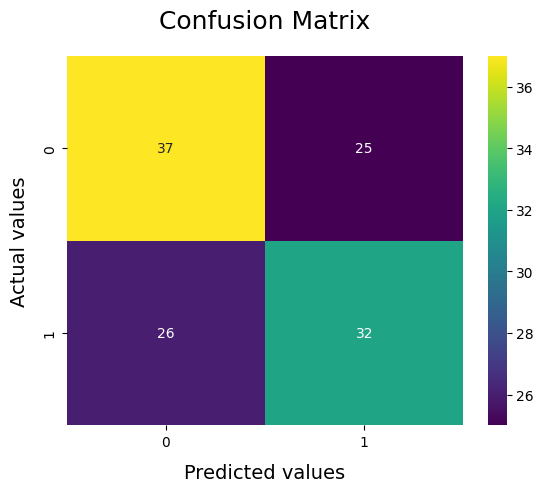

In [98]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_knn_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

#Visualisasi

In [99]:
models = [
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
          ('KNN', accuracy_knn_train, accuracy_knn_test),
         ]

In [100]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,1.000000,0.900
1,KNN,0.839286,0.575


In [101]:
models_comparison = [
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test),
                        ('KNN', accuracy_knn_test, recall_knn_test, precision_knn_test, f1_knn_test),
                    ]

In [102]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.900,0.900,0.900000,0.900000
1,KNN,0.575,0.575,0.574784,0.574852


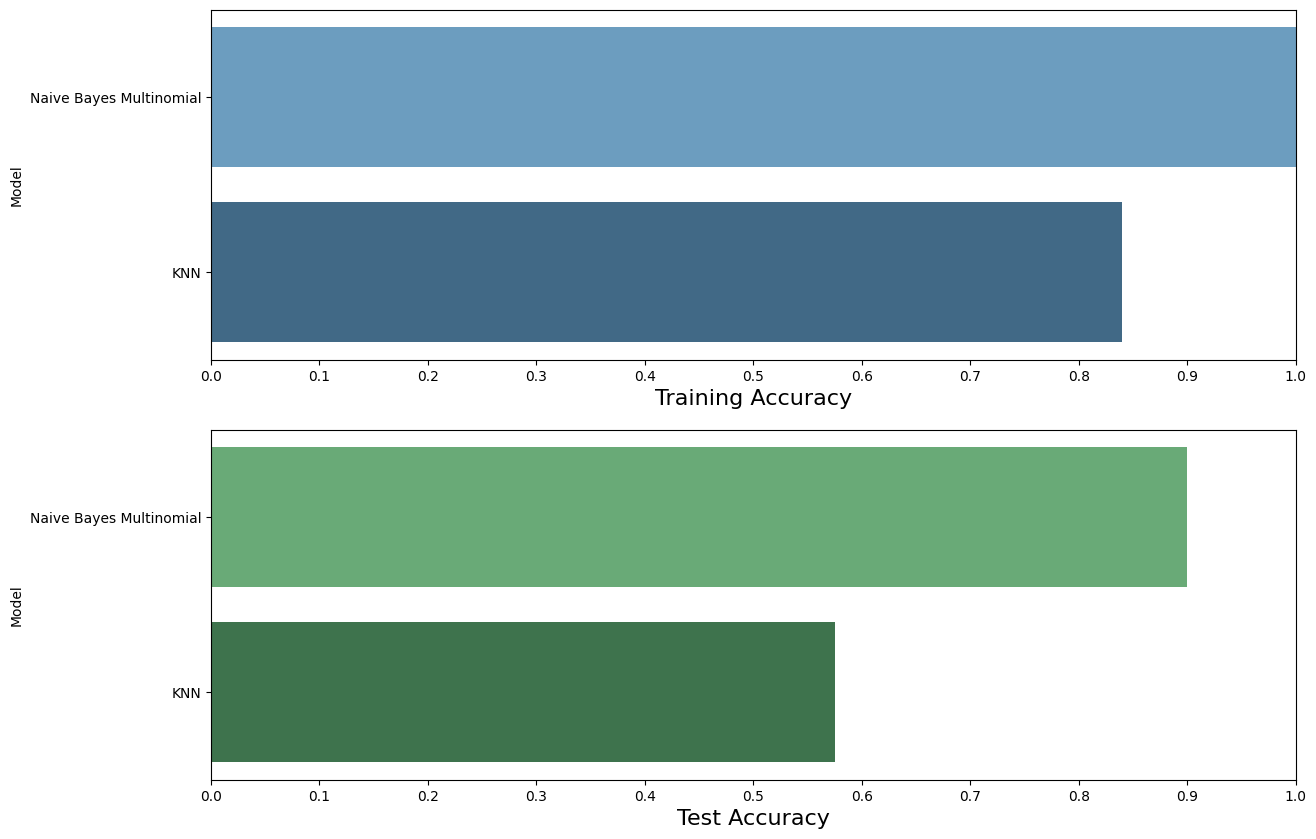

In [104]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()